# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">

Alright, here we are—the grand finale of your semester's ablations, May stars align and the models behave. Welcome to the final assignment in 11785. Let's pause for a moment to shed a single, dramatic tear in honor of all the tensors we've left behind... and then, let’s dive into it! In this HW, you will work on building a speech recognition system with <i>**Transformers**</i>. <br> <br>


<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.



*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.
*  **Understand Masked Multihead Attention**: Understand how masking can help model focus on only relevant parts by applying badding to certain positions and also how we prevent the decoder from seing future tokens (lookahead) while the model is learning.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by training the decoder as a language model, or a conditional language model before full training of the ASR transformer.

* **Decoding**: Learn how convert decoder probabilities to tokens and generate sequences using autoregressive generation. Learn how to use different decoding strategies such as greedy decoding, beam decoding, etc.



*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/t/36ac716957f74cc1826a606c29b70141)<br> Must join competition to get access to data.


[Kaggle Dataset Link](https://www.kaggle.com/competitions/11785-fall-24-hw4p2-transformer-asr/data)<br>


[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>


[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>


# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

In [ ]:
''' Installing some required libraries. '''
%pip install -U transformers -q
%pip install gdown
%pip install torchinfo -q
%pip install wandb
%pip install torchaudio

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"","key":""}')


!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
''' Downloading the dataset. '''

!kaggle competitions download -c 11785-fall-24-hw4p2-transformer-asr

''' Unzipping quickly and quietly. '''
!unzip -q 11785-fall-24-hw4p2-transformer-asr.zip -d ./data

##  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as aF
import torchaudio.transforms as tat
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, Dataset, DataLoader
import gc
import os
from transformers import AutoTokenizer
import yaml
import math
from typing import Literal, List, Optional, Any, Dict, Tuple
import random
import zipfile
import datetime
from torchinfo import summary
import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.fftpack import dct
import seaborn as sns
import matplotlib.pyplot as plt
''' Imports for decoding and distance calculation. '''
import json
import warnings
import shutil
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# Configurations

## Please read the writeup to understand the following configurations.

In [ ]:
%%writefile config.yaml

Name                      : "Your name here"
###### Dataset -----------------------------------------------------------------
root                      : "data/hw4p2"                # TODO: Set the root path of your data
unpaired_text_partition   : "text-for-LM"               # unpaired text for LM pre-training
train_partition           : "train-clean-100"           # train-clean-100
val_partition             : "dev-clean"                 # validation partition
test_partition            : "test-clean"                # test partition
NUM_WORKERS               : 4
subset                    : 1.0        # Load a subset of the data (for debugging, testing, etc)
token_type                : "char"     # [char, 1k, 10k]
feat_type                 : 'fbank'    # ['fbank', 'mfcc']
num_feats                 : 20         # fbanks:[20-80], mfcc:[12:20]
batch_size                : 32
norm                      : 'cepstral' # ['global_mvn', 'cepstral']

###### SpecAugment ---------------------------------------------------------------
specaug                   : False
specaug_conf:
  apply_freq_mask         : False
  freq_mask_width_range   : 4
  num_freq_mask           : 4
  apply_time_mask         : False
  time_mask_width_range   : 50
  num_time_mask           : 8

###### Network Specs -------------------------------------------------------------
d_model                   : 256
d_ff                      : 1024

###### Embedding Specs -----------------------------------------------------------
time_stride               : 4 # time-wise downsampling
feature_stride            : 2 # feature-wise downsampling
embed_dropout             : 0.2

###### Encoder Specs -------------------------------------------------------------
enc_dropout               : 0.2
enc_num_layers            : 2
enc_num_heads             : 4

###### Decoder Specs -------------------------------------------------------------
dec_dropout               : 0.2
dec_num_layers            : 2
dec_num_heads             : 4

###### Base Parameters -----------------------------------------------------------
use_wandb                 : True
use_ctc                   : False
ctc_weight                : 0.0
optimizer                 : "AdamW" # Adam, AdamW, SGD
momentum                  : 0.0
nesterov                  : True
learning_rate             : 2E-4
scheduler                 : "CosineAnnealing" # ['ReduceLR', 'CosineAnnealing']
factor                    : 0.2
patience                  : 2
epochs                    : 60

In [ ]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

# Tokenization in Speech Recognition (HW4P2)

This semester, we're expanding our tokenization approach beyond just character-based tokenization. We've introduced multiple tokenization strategies to explore their impact on speech recognition performance. Let's examine the key differences and improvements:

### Tokenizer Options:
Char based, 1k, 10k, [20k, 50k, 100k] (if your memory supports)

### Implementation:
- The GTokenizer class allows for different tokenization strategies, selected via the token_type parameter.
- For subword tokenizations (1k, 10k, 20K, 50k, 100k), we're using pretrained tokenizers from the Hugging Face library.
- The CharTokenizer class provides a wrapper around character tokenization to maintain a consistent interface with other tokenization strategies.
- The vocabulary size varies significantly based on the chosen tokenization strategy, from 31 for character-based to up to 100k for the largest subword vocabulary.

### Important Considerations:

- With larger vocabularies, consider the dataset size and whether memory-efficient loading techniques are necessary.
- How do we load the audio features? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Consider the trade-offs between different vocabulary sizes:
  - Smaller vocabularies (e.g., character-based) may lead to longer sequences but can handle any input.
  - Larger vocabularies (e.g., 50k subwords) can represent more complex tokens but may struggle with rare words.
  - Looking at the dataset which one should you choose?
- What should be the model architecture (such as the size of embedding layers or the number of encoder/decoder layers) based on choice of tokenization strategy?
- Should you add augmentations, if yes which augmentations? When should you add augmentations, before or after tokenization? (Check bootcamp for answer)


In [ ]:
class CharTokenizer():
    ''' A wrapper around character tokenization to have a consistent interface with other tokeization strategies'''

    def __init__(self):
        # Define special tokens for end-of-sequence, padding, and unknown characters
        self.eos_token = "<|endoftext|>"  # Same as EOS_TOKEN
        self.pad_token = "<|padding|>"
        self.unk_token = "<|unknown|>"

        # Initialize vocabulary with uppercase alphabet characters and space
        characters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ '")

        # Create vocabulary mapping
        self.vocab = {
            self.eos_token: 0,
            self.pad_token: 1,  # Same ID as EOS_TOKEN
            self.unk_token: 2,
        }

        for idx, char in enumerate(characters, start=3):
            self.vocab[char] = idx

        # Create an inverse mapping from IDs to characters for decoding
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

        # Define token IDs for special tokens for easy access
        self.eos_token_id = self.vocab[self.eos_token]
        self.bos_token_id = self.vocab[self.eos_token]
        self.pad_token_id = self.vocab[self.pad_token]
        self.unk_token_id = self.vocab[self.unk_token]

        self.vocab_size = len(self.vocab)

    def tokenize(self, data:str) -> List[str]:
        # Split input data into a list of characters for tokenization
        return [char for char in data]

    def encode(self, data:str, return_tensors:Optional[Literal['pt']]=None) -> List[int]:
        # Encode each character in data to its integer ID, using unk_token if character is not in vocab
        e = [self.vocab.get(char.upper(), self.unk_token) for char in data]
        # If specified, convert to PyTorch tensor format
        if return_tensors == 'pt':
            return torch.tensor(e).unsqueeze(0)
        return e

    def decode(self, data:List[int]) -> str:
        # Decode list of token IDs back to string by mapping each ID to its character
        try:
            return ''.join([self.inv_vocab.get(j) for j in data])
        except:
            # Handle decoding error by converting data to list, if it's a tensor
            data = data.cpu().tolist()
            return ''.join([self.inv_vocab.get(j) for j in data])



class GTokenizer:

    def __init__(self, token_type: Literal['1k', '10k', '50k', 'char']='char', logger=None):

        self.token_type = token_type
        self.vocab, self.inv_vocab = None, None
        if token_type == '1k':
            self.tokenizer = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_1k", use_fast=False)
        elif token_type == '10k':
            self.tokenizer = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_10k", use_fast=False)
        elif token_type == '20k':
            self.tokenizer = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_20k", use_fast=False)
        elif token_type == '50k':
            self.tokenizer = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_50k", use_fast=False)
        elif token_type  == '100k':
            self.tokenizer = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_100k", use_fast=False)
        elif token_type == 'char':
            self.tokenizer = CharTokenizer()

        self.EOS_TOKEN  = self.tokenizer.eos_token_id
        self.SOS_TOKEN  = self.tokenizer.bos_token_id
        self.PAD_TOKEN  = self.tokenizer.convert_tokens_to_ids('<|padding|>') if self.token_type != "char" else self.tokenizer.pad_token_id
        self.UNK_TOKEN  = self.tokenizer.unk_token_id
        self.VOCAB_SIZE = self.tokenizer.vocab_size

        # Test tokenization methods to ensure everything is working correctly
        test_text = "HI DEEP LEARNERS"
        test_tok  = self.tokenize(test_text)
        test_enc  = self.encode(test_text)
        test_dec  = self.decode(test_enc)

        print(f"[Tokenizer Loaded]: {token_type}")
        print(f"\tEOS_TOKEN:  {self.EOS_TOKEN}")
        print(f"\tSOS_TOKEN:  {self.SOS_TOKEN}")
        print(f"\tPAD_TOKEN:  {self.PAD_TOKEN}")
        print(f"\tUNK_TOKEN:  {self.UNK_TOKEN}")
        print(f"\tVOCAB_SIZE: {self.VOCAB_SIZE}")
        print("Examples:")
        print(f"\t[DECODE EOS, SOS, PAD, UNK] : {self.decode([self.EOS_TOKEN, self.SOS_TOKEN, self.PAD_TOKEN, self.UNK_TOKEN])}")
        print(f"\t[Tokenize HI DEEP LEARNERS] : {test_tok}")
        print(f"\t[Encode   HI DEEP LEARNERS] : {test_enc}")
        print(f"\t[Decode   HI DEEP LEARNERS] : {test_dec}")



    def tokenize(self, data:str) -> List[str]:
        return self.tokenizer.tokenize(data)

    def encode(self, data:str, return_tensors=False) -> List[int]:
        if return_tensors:
            return self.tokenizer.encode(data, return_tensors='pt')
        return self.tokenizer.encode(data)

    def decode(self, data:List[int]) -> str:
        return self.tokenizer.decode(data)

## Instantiate your tokenizer of choice

In [ ]:
Tokenizer = GTokenizer(config['token_type'])

# Data

## Speech Features - Text Paired Dataset (TODO)
The `SpeechDataset` class is a PyTorch `Dataset` for loading, processing, and preparing speech data. It handles feature extraction, tokenization, and optional feature augmentation, specifically for speech-based tasks.
You will use this to train a Transformer ASR model.

In [ ]:
class SpeechDataset(Dataset):

    def __init__(self,
                 partition:Literal['train-clean-100', 'dev-clean', 'test-clean'],
                 config:dict,
                 tokenizer:GTokenizer,
                 isTrainPartition:bool
                 ):
        """
        Initialize the SpeechDataset.

        Args:
            partition (str): Partition name
            config (dict): Configuration dictionary for dataset settings.
            tokenizer (GTokenizer): Tokenizer class for encoding and decoding text data.
            isTrainPartition (bool): Flag indicating if this partition is for training.
        """

        # general: Get config values
        self.config           = config
        self.root             = self.config['root']
        self.partition        = partition
        self.isTrainPartition = isTrainPartition
        self.tokenizer = tokenizer
        self.eos_token = tokenizer.EOS_TOKEN
        self.sos_token = tokenizer.SOS_TOKEN
        self.pad_token = tokenizer.PAD_TOKEN
        self.subset    = self.config['subset']
        self.feat_type = self.config['feat_type']
        self.num_feats = self.config['num_feats']
        self.norm      = self.config['norm'] 

        # paths | files
        self.fbank_dir   = os.path.join(self.root, self.partition, "fbank")
        self.fbank_files = sorted(os.listdir(self.fbank_dir))
        subset           = int(self.subset * len(self.fbank_files))
        self.fbank_files = sorted(os.listdir(self.fbank_dir))[:subset]

        if self.partition != 'test-clean':
          self.text_dir    = os.path.join(self.root, self.partition, "text")
          self.text_files  = sorted(os.listdir(self.text_dir))
          self.text_files  = sorted(os.listdir(self.text_dir))[:subset]
          assert len(self.fbank_files) == len(self.text_files), "Number of fbank files and text files must be the same"

        self.length = len(self.fbank_files)
        self.feats, self.transcripts_shifted, self.transcripts_golden = [], [], []


        for i in tqdm(range(len(self.fbank_files)), desc=f"Loading fbank and transcript data for {self.partition}"):
            # load features
            feats = np.load(os.path.join(self.fbank_dir, self.fbank_files[i]))
            if self.feat_type == 'mfcc':
                feats = self.fbank_to_mfcc(feats)

            if self.config['norm'] == 'cepstral':
                feats = (feats - np.mean(feats, axis=0)) / (np.std(feats, axis=0) + 1E-8)

            self.feats.append(feats[:self.num_feats, :])

            # load and encode transcripts
            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            if self.partition != 'test-clean':
              # Note: You dont have access to transcripts in dev_clean
              transcript = np.load(os.path.join(self.text_dir, self.text_files[i])).tolist()
              transcript = "".join(transcript)
              #Invoke our tokenizer to tokenize the string
              tokenized  = self.tokenizer.encode(transcript)
              ## TODO: How will you use tokenized?
              self.transcripts_shifted.append(NotImplemented)
              self.transcripts_golden.append(NotImplemented)

        if self.partition != 'test-clean':
          assert len(self.feats) == len(self.transcripts_shifted) == len(self.transcripts_golden)

        # precompute global stats for global mean and variance normalization
        self.global_mean, self.global_std = None, None
        if self.config['norm'] == 'global_mvn':
            self.global_mean, self.global_std = self.compute_global_stats()

        # Torch Audio Transforms
        # time masking
        self.time_mask = NotImplemented
        
        # frequency masking
        self.freq_mask = NotImplemented


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        feat = torch.FloatTensor(self.feats[idx])
        shifted_transcript, golden_transcript = None, None
        if self.partition != 'test-clean':
          shifted_transcript = torch.LongTensor(self.transcripts_shifted[idx])
          golden_transcript = torch.LongTensor(self.transcripts_golden[idx])
        # Apply global mean and variance normalization if enabled
        if self.global_mean is not None and self.global_std is not None:
            feat = (feat - self.global_mean.unsqueeze(1)) / (self.global_std.unsqueeze(1) + 1e-8)
        return feat, shifted_transcript, golden_transcript

    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''
        # Prepare batch (features)
        batch_feats      = NotImplemented # TODO: position of feats do you return from get_item + transpose B x T x F
        lengths_feats    = NotImplemented # Lengths of each T x F sequence
        batch_feats_pad  = NotImplemented # Pad sequence
        
        if self.partition != 'test-clean':
          batch_transcript   = NotImplemented # TODO: # B x T
          batch_golden       = NotImplemented # TODO # B x T
          lengths_transcript = NotImplemented # Lengths of each T
          batch_transcript_pad = NotImplemented
          batch_golden_pad     = NotImplemented

        # TODO: do specaugment transforms
        if self.config["specaug"] and self.isTrainPartition:

            # transpose back to F x T to apply transforms
            batch_feats_pad = NotImplemented

            # shape should be B x num_feats x T
            assert batch_feats_pad.shape[1] == self.num_feats
            
            # freq_mask
            if self.config["specaug_conf"]["apply_freq_mask"]:
              for _ in range(self.config["specaug_conf"]["num_freq_mask"]):
                batch_feats_pad = NotImplemented
            
            # time mask
            if self.config["specaug_conf"]["apply_time_mask"]:
              for _ in range(self.config["specaug_conf"]["num_time_mask"]):
                batch_feats_pad = NotImplemented

            # transpose back to T x F
            batch_feats_pad = NotImplemented
            # shape should be B x T x num_feats
            assert batch_feats_pad.shape[1] == self.num_feats

        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted label
        if self.partition != 'test-clean':
          return batch_feats_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_feats), torch.tensor(lengths_transcript)
        else:
          return batch_feats_pad, None, None, torch.tensor(lengths_feats), None

    def fbank_to_mfcc(self, fbank):
        # Helper function that applies the dct to the filterbank features to concert them to mfccs
        mfcc = dct(fbank.T, type=2, axis=1, norm='ortho')
        return mfcc.T

    #Will be discussed in bootcamp
    def compute_global_stats(self):
        raise NotImplementedError


## Text Unpaired Dataset (Decoder LM Pre-Training)
The `TextDataset` class is a PyTorch `Dataset` for handling text data. It loads and tokenizes text transcripts from files, applies start-of-sequence and end-of-sequence tokens, and provides methods to retrieve and batch data.
You will use this to pre-train a Transformer decoder as an LM before optionally using it along with the Encoder for the ASR task

In [ ]:
class TextDataset(Dataset):
    def __init__(self, partition: str, config:dict, tokenizer: GTokenizer):
        """
        Initializes the TextDataset class, which loads and tokenizes transcript files.

        Args:
            partition (str): Subdirectory under root that specifies the data partition (e.g., 'train', 'test').
            config (dict): Configuration dictionary for dataset settings.
            tokenizer (GTokenizer): Tokenizer instance for encoding transcripts into token sequences.
        """

        # General attributes
        self.root      = config['root']
        self.subset    = config['subset']
        self.partition = partition
        self.tokenizer = tokenizer
        self.eos_token = tokenizer.EOS_TOKEN  # End of sequence token
        self.sos_token = tokenizer.SOS_TOKEN  # Start of sequence token
        self.pad_token = tokenizer.PAD_TOKEN  # Padding token

        # Paths and files
        self.text_dir = os.path.join(self.root, self.partition)  # Directory containing transcript files
        self.text_files = sorted(os.listdir(self.text_dir))  # Sorted list of transcript files

        # Limit to subset of files if specified
        subset = int(self.subset * len(self.text_files))
        self.text_files = self.text_files[:subset]
        self.length = len(self.text_files)

        # Storage for encoded transcripts
        self.transcripts_shifted, self.transcripts_golden = [], []

        # Load and encode transcripts
        for file in tqdm(self.text_files, desc=f"Loading transcript data for {partition}"):
            transcript = np.load(os.path.join(self.text_dir, file)).tolist()
            transcript = " ".join(transcript.split())  # Process text
            tokenized = self.tokenizer.encode(transcript)  # Tokenize transcript
            # Store shifted and golden versions of transcripts
            self.transcripts_shifted.append(np.array([self.eos_token] + tokenized))
            self.transcripts_golden.append(np.array(tokenized + [self.eos_token]))

    def __len__(self) -> int:
        """Returns the total number of transcripts in the dataset."""
        return self.length

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        """
        Retrieves the shifted and golden version of the transcript at the specified index.

        Args:
            idx (int): Index of the transcript to retrieve.

        Returns:
            Tuple[torch.LongTensor, torch.LongTensor]: Shifted and golden version of the transcript.
        """
        shifted_transcript = torch.LongTensor(self.transcripts_shifted[idx])
        golden_transcript = torch.LongTensor(self.transcripts_golden[idx])
        return shifted_transcript, golden_transcript

    def collate_fn(self, batch: List[Tuple[torch.LongTensor, torch.LongTensor]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Collates a batch of transcripts for model input, applying padding as needed.

        Args:
            batch (List[Tuple[torch.LongTensor, torch.LongTensor]]): Batch of (shifted, golden) transcripts.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Padded shifted transcripts (batch_transcript_pad).
                - Padded golden transcripts (batch_golden_pad).
                - Lengths of shifted transcripts.
        """

        # Separate shifted and golden transcripts from batch
        batch_transcript = [i[0] for i in batch]  # B x T
        batch_golden = [i[1] for i in batch]  # B x T
        lengths_transcript = [len(i) for i in batch_transcript]

        # Pad sequences
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True, padding_value=self.pad_token)
        batch_golden_pad = pad_sequence(batch_golden, batch_first=True, padding_value=self.pad_token)

        # Return padded sequences and lengths
        return batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_transcript)


## Datasets

In [ ]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
train_dataset   = SpeechDataset(
    partition   = config['train_partition'],
    config      = config,
    tokenizer   = Tokenizer,
    isTrainPartition = True,
)


val_dataset     = SpeechDataset(
    partition   = config['val_partition'],
    config      = config,
    tokenizer   = Tokenizer,
    isTrainPartition = False,
)


test_dataset    = SpeechDataset(
    partition   = config['test_partition'],
    config      = config,
    tokenizer   = Tokenizer,
    isTrainPartition = False,
)

'''
# UNCOMMENT if pretraining decoder as LM
text_dataset   = TextDataset(
     partition  = config['unpaired_text_partition'],
     config     = config,
     tokenizer  = Tokenizer,
)
'''

## DataLoaders

In [ ]:
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = config['NUM_WORKERS'],
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)


val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = 4,
    shuffle     = False,
    num_workers = config['NUM_WORKERS'],
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn
)


test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = config['NUM_WORKERS'],
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

'''
# UNCOMMENT if pretraining decoder as LM
text_loader     = DataLoader(
   dataset       = text_dataset,
   batch_size    = config["batch_size"],
   shuffle       = True,
   num_workers   = config['NUM_WORKERS'],
   pin_memory    = True,
   collate_fn    = text_dataset.collate_fn
)
'''

### Dataset Verification and Analysis Overview

This verifies and analyzes properties of both paired (audio-transcript) and unpaired (transcript-only) datasets in a speech-text processing pipeline. The main steps are:

1. **Dataset Verification**:
   - The `verify_dataset` function iterates through the data loader, identifying the maximum sequence lengths for both:
     - **MFCC feature length** (`max_len_feat`)
     - **Transcript length** (`max_len_t`)
   - This check is performed on both paired datasets (audio-transcript) and, optionally, on the unpaired transcript dataset for potential language model pretraining.

2. **Dataset Statistics**:
   - It prints key statistics such as:
     - Number of samples
     - Batch size
     - Number of batches for both training and validation sets

3. **Batch Structure Validation**:
   - Using a sample batch from `train_loader`, it:
     - Prints the shape of padded input features (`x_pad`), feature lengths (`x_len`), and padded shifted/golden transcripts (`y_shifted_pad` and `y_golden_pad`)
     - Decodes and prints one transcript for manual verification of tokenized text accuracy

4. **Max Length Calculation**:
   - Computes the maximum feature and transcript lengths across the entire dataset (training and validation combined) for efficient padding during model training.

5. **Feature Visualization**:
   - Displays a heatmap of the first sample’s feature matrix (`x_pad`), showing the temporal structure of the MFCC feature representation.

This process is essential to ensure dataset consistency, verify data preparation, and inspect the data format before model training.


In [ ]:
def verify_dataset(dataloader, partition):
    '''Compute the Maximum MFCC and Transcript sequence length in a dataset'''
    print("Loaded Path: ", partition)
    max_len_feat = 0
    max_len_t    = 0  # To track the maximum length of transcripts

    # Iterate through the dataloader
    for batch in tqdm(dataloader, desc=f"Verifying {partition} Dataset"):
      try:
        x_pad, y_shifted_pad, y_golden_pad, x_len, y_len = batch

        # Update the maximum feat length
        len_x = x_pad.shape[1]
        if len_x > max_len_feat:
            max_len_feat = len_x

        # Update the maximum transcript length
        # transcript length is dim 1 of y_shifted_pad
        if y_shifted_pad is not None:
          len_y = y_shifted_pad.shape[1]
          if len_y > max_len_t:
              max_len_t = len_y

      except Exception as e:
        # The text dataset has no transcripts
        y_shifted_pad, y_golden_pad, y_len = batch

        # Update the maximum transcript length
        # transcript length is dim 1 of y_shifted_pad
        len_y = y_shifted_pad.shape[1]
        if len_y > max_len_t:
            max_len_t = len_y


    print(f"Maximum Feat Length in Dataset       : {max_len_feat}")
    print(f"Maximum Transcript Length in Dataset : {max_len_t}")
    return max_len_feat, max_len_t

print('')
print("Paired Data Stats: ")
print(f"No. of Train Feats   : {train_dataset.__len__()}")
print(f"Batch Size           : {config['batch_size']}")
print(f"Train Batches        : {train_loader.__len__()}")
print(f"Val Batches          : {val_loader.__len__()}")
# print(f"Test Batches         : {test_loader.__len__()}")
print('')
print("Checking the Shapes of the Data --\n")
for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch
    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}")

    if y_shifted_pad is not None and y_golden_pad is not None and y_len is not None:
      print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
      print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
      print(f"y_len shape:\t\t{y_len.shape}\n")
      # convert one transcript to text
      transcript = train_dataset.tokenizer.decode(y_shifted_pad[0].tolist())
      print(f"Transcript Shifted: {transcript}")
      transcript = train_dataset.tokenizer.decode(y_golden_pad[0].tolist())
      print(f"Transcript Golden: {transcript}")
    break
print('')
'''
# UNCOMMENT if pretraining decoder as LM
print("Unpaired Data Stats: ")
print(f"No. of text          : {text_dataset.__len__()}")
print(f"Batch Size           : {config['batch_size']}")
print(f"Train Batches        : {text_loader.__len__()}")
print('')
print("Checking the Shapes of the Data --\n")
for batch in text_loader:
     y_shifted_pad, y_golden_pad, y_len, = batch
     print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
     print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
     print(f"y_len shape:\t\t{y_len.shape}\n")

     # convert one transcript to text
     transcript = text_dataset.tokenizer.decode(y_shifted_pad[0].tolist())
     print(f"Transcript Shifted: {transcript}")
     transcript = text_dataset.tokenizer.decode(y_golden_pad[0].tolist())
     print(f"Transcript Golden: {transcript}")
     break
print('')
'''
print("\n\nVerifying Datasets")
max_train_feat, max_train_transcript = verify_dataset(train_loader, config['train_partition'])
max_val_feat, max_val_transcript     = verify_dataset(val_loader,   config['val_partition'])
max_test_feat, max_test_transcript   = verify_dataset(test_loader,  config['test_partition'])
#_, max_text_transcript               = verify_dataset(text_loader,  config['unpaired_text_partition'])

MAX_SPEECH_LEN = max(max_train_feat, max_val_feat, max_test_feat)
MAX_TRANS_LEN  = max(max_train_transcript, max_val_transcript)
print(f"Maximum Feat. Length in Entire Dataset      : {MAX_SPEECH_LEN}")
print(f"Maximum Transcript Length in Entire Dataset : {MAX_TRANS_LEN}")
print('')
gc.collect()

plt.figure(figsize=(10, 6))
plt.imshow(x_pad[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Features')
plt.title('Feature Representation')
plt.show()

# Introduction

Transformers have proven highly effective for speech recognition due to their self-attention mechanisms, which allow them to process entire sequences of audio data simultaneously. This enables the model to capture long-range dependencies and complex temporal dynamics essential for understanding spoken language. Compared to traditional models, transformers offer significant gains in accuracy and efficiency, handling diverse speech patterns, accents, and intonations with ease, making them ideal for advanced speech recognition tasks.

In this assignment, training will be structured to optimize both the complexity of the model and the limited availability of data and computational resources. We offer three training strategies, allowing you the flexibility to experiment with any or all approaches to achieve the best results:

### Training Strategies

1. **Pre-training the Transformer Decoder as a Language Model (LM)**:
   - This strategy focuses on pre-training the transformer decoder as a language model on text data alone. This equips the decoder with an understanding of the language’s structure, syntax, and word patterns, offering a solid foundation before any audio data is introduced.
   - By establishing this baseline, the decoder can generate realistic text sequences, which can significantly enhance performance when paired with limited audio-text data in later stages.

2. **Pre-training the Transformer Decoder as a Conditional Language Model with Conv2D + LSTM Embeddings**:
   - Here, the transformer decoder is trained as a conditional language model, taking in audio features that have been processed through a Conv2D and LSTM stack. These embeddings serve as conditional inputs to the decoder, helping it to start learning the mappings between audio patterns and text outputs.
   - This phase accelerates learning by conditioning the model on audio data, allowing for smoother transition into full training.

3. **Full Training with a Transformer Encoder-Decoder Architecture**:
   - In the final phase, both the encoder and decoder are trained together as a complete transformer encoder-decoder model. The encoder processes raw audio features, extracting key representations that the decoder then converts into text.
   - This end-to-end approach refines the model’s ability to transcribe complex audio inputs into text, integrating insights from the pre-training steps to enhance performance on the speech recognition task.

By exploring these strategies individually or in combination, you can determine the most effective training path for optimal results.


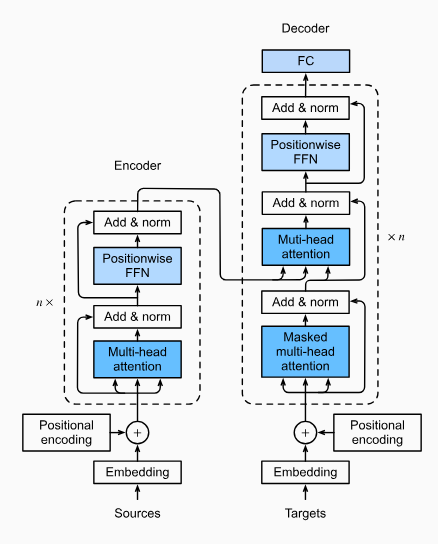


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

## Masking in Transformers for Sequence Modeling (TODO)

This task focuses on implementing two types of masks used in transformers for sequence modeling: **padding masks** and **causal masks**. These masks are crucial for handling variable-length sequences and ensuring proper attention flow in self-attention mechanisms, particularly in transformer architectures used for tasks such as language modeling, machine translation, and speech recognition.

### Padding Mask

In transformers, inputs are often padded to a uniform length to form batches. However, the attention mechanism should not attend to these padding tokens, as they do not carry meaningful information. The `PadMask` function creates a binary or boolean mask to identify and ignore padding tokens during attention.

- **Function**: `PadMask`
  - **Input**: A padded input tensor of shape `(N, T, ...)`, where `N` is the batch size and `T` is the maximum sequence length in the batch. This function also accepts an optional `input_lengths` tensor representing the actual lengths of each sequence before padding, and a `pad_idx` (padding token index).
  - **Output**: A mask of shape `(N, T)` where non-padding positions are marked as `1` and padding positions are marked as `0`.

The `PadMask` function checks if `input_lengths` is provided. If so, it creates a mask based on these lengths; otherwise, it infers the mask from the `pad_idx` token.

### Causal Mask

For the transformer decoder, especially in tasks like language modeling, the causal mask ensures that each token only attends to previous tokens, preventing information leakage from future tokens. This is essential for generating sequences in an autoregressive manner, as it ensures that each token prediction is conditioned solely on preceding tokens.

- **Function**: `CausalMask`
  - **Input**: A tensor of shape `(N, T, ...)` for which a causal mask is required.
  - **Output**: A lower triangular causal mask of shape `(T, T)`, where each position `(i, j)` is `1` if `j <= i` and `0` otherwise.

The `CausalMask` function generates a lower triangular matrix, setting positions above the main diagonal to `0`, thereby preventing attention to future tokens in the sequence.

### Testing the Masks

To visualize and verify the padding and causal masks:

1. Dummy encoder and decoder input tensors are created, along with their corresponding lengths.
2. The `PadMask` is applied to the encoder and decoder inputs, producing the encoder and decoder padding masks.
3. The `CausalMask` is applied to the decoder input, yielding a causal mask for autoregressive self-attention.

Each mask is visualized as a grayscale image:
- **Encoder Padding Mask**: Black areas represent positions where padding is ignored in the encoder input.
- **Decoder Padding Mask**: Black areas indicate padding positions in the decoder input.
- **Decoder Causal Mask**: Black areas enforce causality, blocking attention to future positions in the sequence.

Ensure your image matches the expected image below before proceeding to the next sections:


Expected image of masks
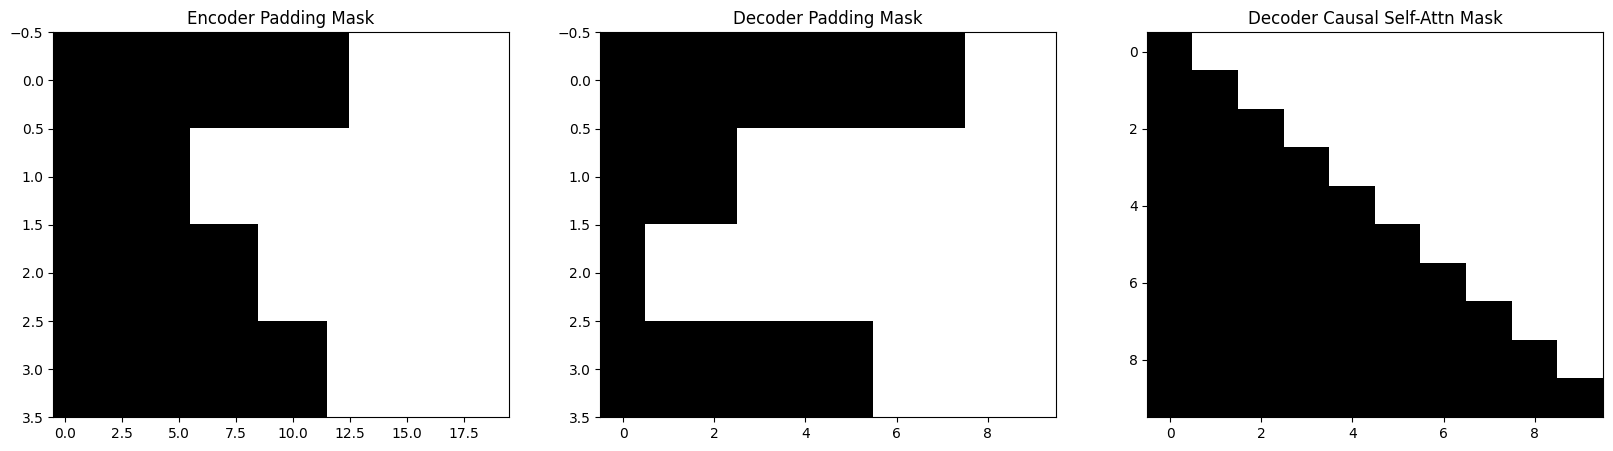

In [ ]:
def PadMask(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T), where padding positions are marked with 1 and non-padding positions are marked with 0.
    """

    # If input is a 2D tensor (N, T), add an extra dimension
    if padded_input.dim() == 2:
        padded_input = padded_input.unsqueeze(-1)

    # TODO: Initialize the mask variable here. What type should it be and how should it be initialized?

    if input_lengths is not None:
        # TODO: Use the provided input_lengths to create the mask.
        N, T, _ = padded_input.shape
        for i in range(N):

            # TODO: Set non-padding positions to False based on input_lengths
            pass
    else:
        # TODO: Infer the mask from the padding index.
        mask = (padded_input.squeeze(-1) == pad_idx)  # Shape (N, T)

    return mask


def CausalMask(input_tensor):
    """
    Create an attention mask for causal self-attention based on input lengths.

    Args:
        input_tensor (torch.Tensor): The input tensor of shape (N, T, *).

    Returns:
        attn_mask (torch.Tensor): The causal self-attention mask of shape (T, T)
    """
    T = input_tensor.shape[1]  # Sequence length
    # TODO: Initialize attn_mask as a tensor of zeros with the right shape.
    attn_mask = NotImplemented # Shape (T, T)

    # TODO: Create a lower triangular matrix to form the causal mask.
    causal_mask = NotImplemented  # Lower triangular matrix

    # TODO: Combine the initial mask with the causal mask.
    attn_mask = attn_mask | causal_mask

    return attn_mask



# Test w/ dummy inputs
enc_inp_tensor     = torch.randn(4, 20, 32)  # (N, T,  *)
dec_inp_tensor     = torch.randn(4, 10)       # (N, T', *)
enc_inp_lengths    = torch.tensor([13, 6, 9, 12])   # Lengths of input sequences before padding
dec_inp_lengths    = torch.tensor([8, 3, 1, 6])   # Lengths of target sequences before padding


enc_padding_mask        = PadMask(padded_input=enc_inp_tensor, input_lengths=enc_inp_lengths)
dec_padding_mask        = PadMask(padded_input=dec_inp_tensor, input_lengths=dec_inp_lengths)
dec_causal_mask         = CausalMask(input_tensor=dec_inp_tensor)

# Black portions are attended to
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(enc_padding_mask, cmap="gray", aspect='auto')
axs[0].set_title("Encoder Padding Mask")
axs[1].imshow(dec_padding_mask, cmap="gray", aspect='auto')
axs[1].set_title("Decoder Padding Mask")
axs[2].imshow(dec_causal_mask, cmap="gray", aspect='auto')
axs[2].set_title("Decoder Causal Self-Attn Mask")


plt.show()


## Transformer Modules

### Positional Encoding in Transformers

Positional encoding is a technique introduced in the "Attention Is All You Need" paper to allow transformers to retain information about the order of input tokens, as transformers lack inherent sequential understanding due to their non-recurrent architecture. \

The `PositionalEncoding` class defines the positional encoding layer, which generates fixed positional encodings that are added to the input embeddings to incorporate sequence order information.




In [ ]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
      return x + self.pe[:, :x.size(1)]

### Speech Embedding Architecture (Conv2D Subsampling + BiLSTM)

This implements a speech embedding module that uses Conv2D-based subsampling followed by a BiLSTM (Bidirectional Long Short-Term Memory) layer to process speech signals. The approach integrates downsampling to make training more efficient and tractable, particularly when dealing with long sequence lengths. You will have to manage the tradeoff between training tractability and model performance by tweaking the amount of feature-wise and time-wise downsampling (`time_stride` and `feature_stride` parameters in the `config`.

### Key Components

1. **BiLSTMEmbedding (2-Layer BiLSTM)**:
   - This module applies a BiLSTM to the input tensor, enabling the model to learn bidirectional temporal dependencies.
   - NOTE: This is only used during the 2nd training strategy and is bypassed during full training to fully leverage the the superior parallelization abilitiesand the ability to capture long-range dependencies through self-attention of the Transformer Encoder.
   

2. **Conv2DSubsampling**:
   - This module performs downsampling in both the time and feature dimensions of the input using 2D convolutions. This reduces the dimensionality of the input while retaining relevant features.
   - The use of convolution for subsampling helps in reducing the sequence length and feature size progressively, making the model more computationally efficient.
   - The downsampling process is implemented with two consecutive `Conv2d` layers, followed by ReLU activations.

3. **SpeechEmbedding**:
   - This combines the `Conv2DSubsampling` and `BiLSTMEmbedding` modules. The input is first downsampled using the `Conv2DSubsampling`, and then passed through the BiLSTM if specified (`use_blstm=True`).
   - **Time Stride & Feature Stride**: These parameters define how much the time and feature dimensions will be downsampled in the Conv2D layer, making the computation more efficient for longer sequences.

In [ ]:
# 2-Layer BiLSTM
class BiLSTMEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(BiLSTMEmbedding, self).__init__()
        self.bilstm = nn.LSTM(
                input_dim, output_dim // 2,
                num_layers=1,
                batch_first=True,
                bidirectional=True,
                dropout=dropout
        )

    def forward(self, x,  x_len):
        """
        Args:
            x.    : Input tensor (batch_size, seq_len, input_dim)
            x_len : Non-padded lengths (batch_size)
        Returns:
            Output tensor (batch_size, seq_len, output_dim)
        """
        # BiLSTM expects (batch_size, seq_len, input_dim)
        # Pack the padded sequence to avoid computing over padded tokens
        packed_input = pack_padded_sequence(x, x_len.cpu(), batch_first=True, enforce_sorted=False)
        # Pass through the BiLSTM
        packed_output, _ = self.bilstm(packed_input)
        # Unpack the sequence to restore the original padded shape
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        return output

### DO NOT MODIFY

class Conv2DSubsampling(torch.nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.0, time_stride=2, feature_stride=2):
        """
        Conv2dSubsampling module that can selectively apply downsampling
        for time and feature dimensions, and calculate cumulative downsampling factor.
        Args:
            time_stride (int): Stride along the time dimension for downsampling.
            feature_stride (int): Stride along the feature dimension for downsampling.
        """
        super(Conv2DSubsampling, self).__init__()

        # decompose to get effective stride across two layers
        tstride1, tstride2 = self.closest_factors(time_stride)
        fstride1, fstride2 = self.closest_factors(feature_stride)

        self.feature_stride = feature_stride
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, output_dim, kernel_size=3, stride=(tstride1, fstride1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=(tstride2, fstride2)),
            torch.nn.ReLU(),
        )
        self.time_downsampling_factor = tstride1 * tstride2
        # Calculate output dimension for the linear layer
        conv_out_dim = (input_dim - (3 - 1) - 1) // fstride1 + 1
        conv_out_dim = (conv_out_dim - (3 - 1) - 1) // fstride2 + 1
        conv_out_dim = output_dim * conv_out_dim
        self.out = torch.nn.Sequential(
            torch.nn.Linear(conv_out_dim, output_dim),
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).
            x_mask (torch.Tensor): Optional mask for the input tensor.

        Returns:
            torch.Tensor: Downsampled output of shape (batch_size, new_seq_len, output_dim).
        """
        x = x.unsqueeze(1)  # Add a channel dimension for Conv2D
        x = self.conv(x)
        b, c, t, f = x.size()
        x = self.out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        return x

    def closest_factors(self, n):
        factor = int(n**0.5)
        while n % factor != 0:
            factor -= 1
        # Return the factor pair
        return max(factor, n // factor), min(factor, n // factor)



class SpeechEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim, time_stride, feature_stride, dropout):
        super(SpeechEmbedding, self).__init__()

        self.cnn = Conv2DSubsampling(input_dim, output_dim, dropout=dropout, time_stride=time_stride, feature_stride=feature_stride)
        self.blstm = BiLSTMEmbedding(output_dim, output_dim, dropout)
        self.time_downsampling_factor = self.cnn.time_downsampling_factor

    def forward(self, x, x_len, use_blstm: bool = False):
        """
        Args:
            x    : Input tensor (batch_size, seq_len, input_dim)
            x_len : Non-padded lengths (batch_size)
        Returns:
            Output tensor (batch_size, seq_len // stride, output_dim)
        """
        # First, apply Conv2D subsampling
        x = self.cnn(x)
        # Adjust sequence length based on downsampling factor
        x_len = torch.ceil(x_len.float() / self.time_downsampling_factor).int()
        x_len = x_len.clamp(max=x.size(1))

        # Apply BiLSTM if requested
        if use_blstm:
            x = self.blstm(x, x_len)

        return x, x_len


## Transformer Encoder (TODO)

- **Input:** $B \times T \times d_{\text{model}}$
- **Output:** $B \times T \times d_{\text{model}}$

Here you will implement a Transformer encoder. The transformer encoder is central to a speech transformer model, enabling the processing and understanding of spoken language. Below is a breakdown of its key roles:

### Purpose of the Encoder:

#### **Feature Extraction:**
The encoder transforms raw speech input into a rich, high-dimensional representation. This allows it to capture essential features of the speech signal, including phonetic content, intonation, rhythm, and other acoustic properties.

#### **Contextual Understanding:**
By leveraging self-attention mechanisms, the encoder considers the broader context in which words are spoken. This allows it to grasp the meaning and relationships between words, improving the model's ability to understand complex linguistic structures and nuances.

#### **Dimensionality Reduction:**
The encoder converts the high-dimensional speech signal into a more manageable lower-dimensional space. This reduces the computational complexity for subsequent processing steps while preserving essential information for accurate interpretation and modeling.

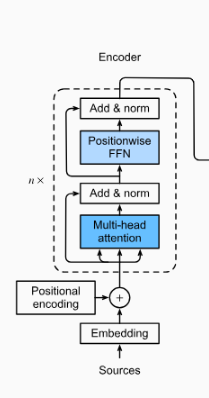

### Encoder Layer

The `EncoderLayer` class defines a single layer of the transformer encoder, which includes multi-head self-attention followed by a feed-forward network (FFN).

### Key Components:

- **Layer Normalization (`pre_norm` and `norm1`, `norm2`):**
  Layer normalization is applied to the inputs before self-attention and feed-forward networks, helping to stabilize training and normalize the feature dimensions.

- **Multi-Head Self-Attention (`self_attn`):**
  This mechanism allows the model to focus on different parts of the input sequence when processing each token. The self-attention process uses multiple attention heads, improving the model’s ability to capture diverse relationships across the sequence.

- **Feed-Forward Network (`ffn1`):**
  This should contain two fully connected layers with a GELU activation in between. It processes the output from the self-attention layer to model more complex interactions. Dropout is applied for regularization.

- **Residual Connections:**
  Both the self-attention and feed-forward components include residual connections that help prevent vanishing gradients and facilitate the flow of information through the network.

- **Dropout (`dropout`):**
  Dropout is applied to prevent overfitting by randomly setting a fraction of input units to zero during training.

---

### Encoder

The `Encoder` class is the complete transformer encoder that consists of multiple `EncoderLayer`s stacked on top of each other. It incorporates positional encoding, dropout for regularization, and a final layer normalization.

### Key Components:

- **Positional Encoding (`pos_encoding`):**  
  Since transformers do not have a built-in mechanism to account for the order of tokens in a sequence, positional encodings are added to the input embeddings to provide the model with information about the relative positions of tokens.

- **Encoder Layers (`enc_layers`):**  
  The encoder consists of multiple layers of the `EncoderLayer` defined earlier. Each layer processes the input sequence and refines its understanding of the relationships between tokens.

- **CTC Head (`ctc_head`):**  
  After passing through the encoder layers, the output is also branched through a linear layer (CTC head) where the encoder outputs are projected to vocab_size. This is to give you the option of experimenting with a CTC objective function as an auxiliary task to train the attention model encoder. The intuition is that the forward-backward algorithm of CTC can enforce monotonic alignment between speech and label sequences which can help the network learn quickly the desired alignments in long sequences.

- **Final Layer Normalization (`after_norm`):**  
  The output of the encoder is normalized before passing it to the next stage in the model.


In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout):

        super(EncoderLayer, self).__init__()

        self.pre_norm = NotImplemented
        self.self_attn = NotImplemented
        self.ffn1 = NotImplemented # Hint: Linear layer - GELU - dropout - Linear layer
        self.dropout = NotImplemented
        self.norm1 = NotImplemented
        self.norm2 = NotImplemented

    def forward(self, x, pad_mask):
        # Step 1: Apply pre-normalization
        ''' TODO '''

        # Step 2: Self-attention with with dropout, and with residual connection
        ''' TODO '''

        # Step 3: Apply normalization
        ''' TODO '''

        # Step 4: Apply Feed-Forward Network (FFN) with dropout, and residual connection
        ''' TODO '''

        # Step 5: Apply normalization after FFN
        ''' TODO '''

        return x, pad_mask



class Encoder(nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 d_ff,
                 max_len,
                 target_vocab_size,
                 dropout=0.1):

        super(Encoder, self).__init__()

        self.pos_encoding = NotImplemented
        self.dropout =  NotImplemented
        self.enc_layers =  NotImplemented
        self.after_norm =  NotImplemented
        self.ctc_head   =  NotImplemented

    def forward(self, x, x_len):

        # Step 1: Create padding mask for inputs
        ''' TODO '''

        # Step 2: Apply positional encoding
        ''' TODO '''

        # Step 3: Apply dropout
        ''' TODO '''

        # Step 4: Add the residual connection (before passing through layers)
        ''' TODO '''

        # Step 5: Pass through all encoder layers
        ''' TODO '''

        # Step 6: Apply final normalization
        ''' TODO '''

        # Step 7: Pass a branch through the CTC head
        ''' TODO '''
        x_ctc = NotImplemented

        return x, x_len, x_ctc.log_softmax(2).permute(1, 0, 2)

## Transformer Decoder (TODO)

- **Input**:  $B \times T \times d_{\text{model}}$  
- **Output**: $B \times T \times \text{vocab-size}$

### Purpose of the Decoder:
- **Decoding Contextual Representation**:  
  The transformer decoder takes the high-dimensional, context-aware representations produced by the encoder and decodes them into a meaningful sequence. In speech-to-text tasks, for example, it transforms the encoded speech features into text transcriptions, effectively mapping the learned context to human-readable output.

- **Autoregressive Output Generation**:  
  The decoder generates the output sequence step-by-step in an autoregressive manner. At each step, it predicts the next token in the sequence based on the current input (from the encoder) and the previously generated tokens from the decoder. This approach ensures that the generation process takes into account both past context and the current token to generate coherent sequences.


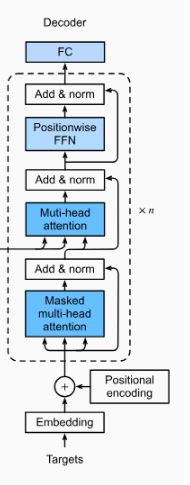

### Decoder Layer

The `DecoderLayer` class defines a single layer of the transformer decoder, which includes multi-head self-attention, cross-attention (encoder-decoder attention), followed by a feed-forward network (FFN).

#### Key Components:

- **Layer Normalization (`pre_norm` and `norm1`, `norm2`, `norm3`):**  
  Layer normalization is applied to the inputs before self-attention, cross-attention, and the feed-forward network. This helps stabilize the learning process and normalize feature dimensions at various stages of the decoder.

- **Masked Multi-Head Self-Attention (`self_attn`):**  
  This attention mechanism operates over the decoder's input sequence, masking future tokens to prevent attending to them. It ensures the autoregressive nature of the decoder, where each token only attends to previous tokens (and not future tokens). Multiple heads improve the model's ability to capture diverse relationships within the sequence.

- **Cross-Attention (Encoder-Decoder Attention, `cross_attn`):**  
  The cross-attention layer attends to the encoder's output, which contains the context from the input sequence. It allows the decoder to focus on relevant parts of the encoder's output sequence when generating predictions, connecting the encoder and decoder. This will switch to the identity operation during LM-pretraining so make sure you handle that when the encoder outputs are `None`

- **Feed-Forward Network (`ffn1`):**  
  Similar to the encoder, the feed-forward network contains two fully connected layers with a GELU activation in between. This network processes the combined information from the attention mechanisms to model complex interactions. Dropout is applied for regularization.

- **Residual Connections:**  
  Each component (self-attention, cross-attention, and feed-forward network) has a residual connection to facilitate gradient flow, making training more stable and mitigating vanishing gradients.

- **Dropout (`dropout`):**  
  Dropout is applied to prevent overfitting by randomly setting a fraction of the input units to zero during training.

---

### Decoder

The `Decoder` class is the complete transformer decoder that consists of multiple `DecoderLayer`s stacked on top of each other. It incorporates positional encoding, dropout for regularization, and a final layer normalization.

#### Key Components:

- **Positional Encoding (`pos_encoding`):**  
  Like the encoder, positional encodings are added to the input embeddings to provide information about the order of tokens in the sequence. This ensures that the decoder understands the relative positions of tokens when generating the output sequence.

- **Decoder Layers (`dec_layers`):**  
  The decoder consists of multiple layers of `DecoderLayer`s, each refining the model's understanding of token dependencies and context over multiple iterations. Each layer combines self-attention and cross-attention to generate more accurate token predictions.

- **Final Linear Layer (`output_linear`):**  
  After processing the input sequence through the decoder layers, a final linear layer is used to map the decoder output to the desired vocabulary size. This helps generate the final predictions, whether for sequence generation tasks (e.g., machine translation, speech generation) or classification.

- **Final Layer Normalization (`after_norm`):**  
  The output of the decoder is normalized before passing it to the next stage in the model, ensuring that the final predictions are stable and ready for downstream tasks.


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = NotImplemented
        self.mha2       = NotImplemented
        self.ffn        = NotImplemented
        self.identity   = NotImplemented
        self.pre_norm   = NotImplemented
        self.layernorm1 = NotImplemented
        self.layernorm2 = NotImplemented
        self.layernorm3 = NotImplemented
        self.dropout1   = NotImplemented
        self.dropout2   = NotImplemented
        self.dropout3   = NotImplemented

    def forward(self, padded_targets, enc_output, pad_mask_enc, pad_mask_dec, slf_attn_mask):

        #   Step 1: Self Attention
        #   (1) pass through the Multi-Head Attention (Hint: you need to store weights here as part of the return value)
        #   (2) add dropout
        #   (3) residual connections
        #   (4) layer normalization

        x = self.pre_norm(padded_targets)

        ''' TODO '''
        mha1_attn_weights = NotImplemented


        #   Step 2: Cross Attention
        #   (1) pass through the Multi-Head Attention (Hint: you need to store weights here as part of the return value)
              #  think about if key,value,query here are the same as the previous one?
        #   (2) add dropout
        #   (3) residual connections
        #   (4) layer normalization

        if enc_output is None:
            mha2_output       = self.identity(padded_targets)
            mha2_attn_weights = torch.zeros_like(mha1_attn_weights)
        else:
            ''' TODO '''
            mha2_attn_weights = NotImplemented

        #   Step 3: Feed Forward Network
        #   (1) pass through the FFN
        #   (2) add dropout
        #   (3) residual connections
        #   (4) layer normalization
        ''' TODO '''
        ffn_output = NotImplemented


        return ffn_output, mha1_attn_weights, mha2_attn_weights


class Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 d_ff, dropout,
                 max_len,
                 target_vocab_size):

        super().__init__()

        self.max_len        = max_len
        self.num_layers     = num_layers
        self.num_heads      = num_heads

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        self.dec_layers = NotImplemented

        self.target_embedding       = NotImplemented  # use torch.nn.Embedding
        self.positional_encoding    = NotImplemented
        self.final_linear           = NotImplemented
        self.dropout                = NotImplemented


    def forward(self, padded_targets, target_lengths, enc_output, enc_input_lengths):

        # Processing targets
        # create a padding mask for the padded_targets with <PAD_TOKEN>
        # creating an attention mask for the future subsequences (look-ahead mask)
        # computing embeddings for the target sequence
        # computing Positional Encodings with the embedded targets and apply dropout

        pad_mask_dec = None
        if target_lengths is not None:
            pad_mask_dec = PadMask(padded_input=padded_targets, input_lengths=target_lengths).to(padded_targets.device)
        causal_mask = CausalMask(input_tensor=padded_targets).to(padded_targets.device)

        # Step1:  Apply the embedding
        ''' TODO '''


        # Step2:  Apply positional encoding
        ''' TODO '''


        # Step3:  Create attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''
        pad_mask_enc = None
        if enc_output is not None:
            pad_mask_enc  = NotImplemented


        # Step4: Pass through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        ''' TODO '''
        runnint_att = {}
        for i in range(self.num_layers):
            x, runnint_att['layer{}_dec_self'.format(i + 1)], runnint_att['layer{}_dec_cross'.format(i + 1)] = NotImplemented


        # Step5: linear layer (Final Projection) for next character prediction
        ''' TODO '''
        seq_out = NotImplemented

        return seq_out, runnint_att


    def recognize_greedy_search(self, enc_output, enc_input_lengths, tokenizer):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network
            @NOTE: You do not need to make changes to this method.
        '''
        # start with the <SOS> token for each sequence in the batch
        batch_size = enc_output.size(0)
        target_seq = torch.full((batch_size, 1), tokenizer.SOS_TOKEN, dtype=torch.long).to(enc_output.device)
        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_output.device)

        for _ in range(self.max_len):

            seq_out, runnint_att = self.forward(target_seq, None, enc_output, enc_input_lengths)
            logits = torch.nn.functional.log_softmax(seq_out[:, -1], dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            # appending the token to the sequence
            # checking if <EOS> token is generated
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            # end if all sequences have generated the EOS token
            next_token = logits.argmax(dim=-1).unsqueeze(1)
            target_seq = torch.cat([target_seq, next_token], dim=-1)
            eos_mask = next_token.squeeze(-1) == tokenizer.EOS_TOKEN
            finished |= eos_mask
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_len - max_length), value=tokenizer.PAD_TOKEN)

        return target_seq

    def recognize_beam_search(self, enc_output, enc_input_lengths, tokenizer):
      # TODO Beam Decoding
      raise NotImplementedError


## Transformer Model (TODO)

The `Transformer` class defines a complete transformer-based model for sequence-to-sequence tasks. This model is designed to process speech inputs and generate corresponding output sequences, such as transcriptions or translations, using both encoder and decoder components.

#### Key Components:

- **Speech Embedding (`embedding`):**  
  The `SpeechEmbedding` class is responsible for embedding the raw speech features into a dense representation suitable for processing by the transformer model. This involves time and feature strides for downsampling, and an optional dropout for regularization. The `embedding` layer also accounts for the maximum length of the input sequence after downsampling.

- **Encoder (`encoder`):**  
  The encoder processes the embedded speech input sequence. It consists of several layers of multi-head self-attention followed by feed-forward networks. The encoder is designed to capture long-range dependencies in the input sequence. It includes:
    - **Positional Encoding:** To encode the relative position of tokens.
    - **Self-Attention and Feed-Forward Networks:** To model relationships within the input sequence.
    - **CTC Head:** Optionally used to train the encoder with the CTC (Connectionist Temporal Classification) objective, helping the model learn alignments between input and target sequences.

- **Decoder (`decoder`):**  
  The decoder generates the output sequence from the encoder's processed input. It uses multi-head self-attention and cross-attention mechanisms to focus on both the previous tokens and the encoder's output. The decoder's components are:
    - **Masked Multi-Head Self-Attention:** To prevent attending to future tokens.
    - **Cross-Attention:** To attend to the encoder's output, allowing the decoder to focus on relevant parts of the input.
    - **Feed-Forward Network:** To model more complex interactions.
    - **Final Linear Layer:** To map the decoder’s output to the target vocabulary space.
  
- **Forward Pass:**  
  The forward method handles three modes of operation:
    - **`full`:** Full training mode where both the encoder and decoder are used.
    - **`dec_cond_lm`:** Decoder training as a conditional language model, where the decoder is trained independently using embeddings from the encoder.
    - **`dec_lm`:** Decoder training as a language model, with no encoder output used.
  
  The forward pass computes the outputs from the encoder and decoder and can include CTC outputs depending on the mode.

- **Recognition (`recognize`):**  
  This method performs sequence-to-sequence decoding using greedy search. It processes an input sequence and generates a corresponding output sequence:
    - **`greedy` Strategy:** Decodes the sequence one token at a time, selecting the most likely token at each step.
    - **`beam` Strategy:** A placeholder for beam search decoding, which would explore multiple possible sequences at each decoding step (currently a TODO).

#### Key Methods:

- **`forward(padded_input, input_lengths, padded_target, target_lengths, mode)`**  
  Runs the model in the specified mode (`full`, `dec_cond_lm`, or `dec_lm`), processes the input through the encoder and decoder, and returns the output along with attention weights and CTC outputs (if applicable).

- **`recognize(inp, inp_len, tokenizer, mode, strategy)`**  
  Performs sequence-to-sequence greedy search or beam search (with the latter still to be implemented). It decodes the input sequence based on the specified mode and strategy.

---

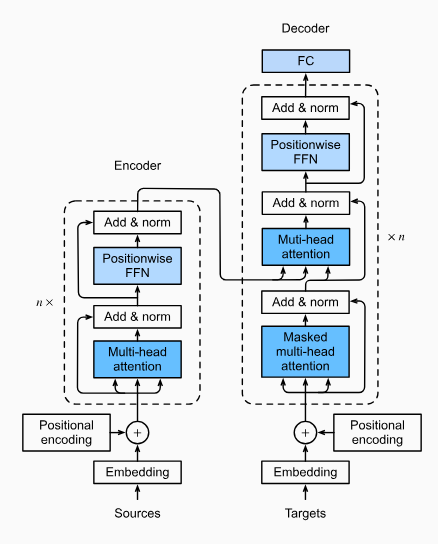

In [ ]:
class Transformer(nn.Module):
    def __init__(self,
                 input_dim,
                time_stride,
                feature_stride,
                embed_dropout,

                d_model,
                enc_num_layers,
                enc_num_heads,
                speech_max_len,
                enc_dropout,

                dec_num_layers,
                dec_num_heads,
                d_ff,
                dec_dropout,

                target_vocab_size,
                trans_max_len):

      super(Transformer, self).__init__()

      self.embedding = SpeechEmbedding(input_dim, d_model, time_stride, feature_stride, embed_dropout)
      speech_max_len = int(np.ceil(speech_max_len/self.embedding.time_downsampling_factor))

      self.encoder   = NotImplemented

      self.decoder = NotImplemented


    def forward(self, padded_input, input_lengths, padded_target, target_lengths, mode:Literal['full', 'dec_cond_lm', 'dec_lm']='full'):
        '''DO NOT MODIFY'''
        if mode == 'full': # Full transformer training
            encoder_output, encoder_lengths          = self.embedding(padded_input, input_lengths, use_blstm=False)
            encoder_output, encoder_lengths, ctc_out = self.encoder(encoder_output, encoder_lengths)
        if mode == 'dec_cond_lm': # Training Decoder as a conditional LM
            encoder_output, encoder_lengths   = self.embedding(padded_input, input_lengths, use_blstm=True)
            ctc_out = None
        if mode == 'dec_lm': # Training Decoder as an LM
            encoder_output, encoder_lengths, ctc_out = None, None, None

        # passing Encoder output through Decoder
        output, attention_weights = self.decoder(padded_target, target_lengths, encoder_output, encoder_lengths)
        return output, attention_weights, ctc_out


    def recognize(self, inp, inp_len, tokenizer, mode:Literal['full', 'dec_cond_lm', 'dec_lm'], strategy:str='greedy'):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """
        '''DO NOT MODIFY'''
        if mode == 'full':
            encoder_output, encoder_lengths          = self.embedding(inp, inp_len, use_blstm=False)
            encoder_output, encoder_lengths, ctc_out = self.encoder(encoder_output, encoder_lengths)
        
        if mode == 'dec_cond_lm':
            encoder_output, encoder_lengths,  = self.embedding(inp, inp_len, use_blstm=True)
            ctc_out = None
      
        if mode == 'dec_lm':
            encoder_output, encoder_lengths, ctc_out = None, None, None
        
        if strategy =='greedy':
          out = self.decoder.recognize_greedy_search(encoder_output, encoder_lengths, tokenizer=tokenizer)
        elif strategy == 'beam':
          out = self.decoder.recognize_beam_search(encoder_output, encoder_lengths, tokenizer=tokenizer, beam_width=5)
        return out

Your config is already set to the early submission architecture.

In [ ]:
model = Transformer(
    input_dim      = x_pad.shape[-1],
    time_stride    = config['time_stride'],
    feature_stride = config['feature_stride'],
    embed_dropout  = config['embed_dropout'],
    d_model        = config['d_model'],
    enc_num_layers = config['enc_num_layers'],
    enc_num_heads  = config['enc_num_heads'],
    speech_max_len = MAX_SPEECH_LEN,
    enc_dropout    = config['enc_dropout'],
    dec_num_layers = config['dec_num_layers'],
    dec_num_heads  = config['dec_num_heads'],
    d_ff           = config['d_ff'],
    dec_dropout    = config['dec_dropout'],
    target_vocab_size = Tokenizer.VOCAB_SIZE,
    trans_max_len     = MAX_TRANS_LEN
)


summary(model.to(device), input_data=[x_pad.to(device), x_len.to(device), y_shifted_pad.to(device), y_len.to(device)])

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Utilities

### Evaluation Metrics: WER, CER, and Levenshtein Distance

To evaluate the performance of the `Transformer` model on sequence-to-sequence tasks, we use three main metrics: **Word Error Rate (WER)**, **Character Error Rate (CER)**, and **Levenshtein Distance**. These metrics assess the model's accuracy by comparing the model's predictions to the reference (ground truth) sequences.

---

#### 1. Word Error Rate (WER)
**WER** measures the edit distance between the predicted and reference sequences at the word level. It’s calculated by splitting both the reference and hypothesis into words, computing the number of word-level insertions, deletions, and substitutions, and normalizing by the total number of words in the reference.

- **Formula:**  
  $
  \text{WER} = \frac{\text{Edit Distance at Word Level}}{\text{Number of Words in Reference}}
  $

- **Interpretation:**  
  Lower WER indicates better alignment between the predicted and reference sequences at the word level.

---

#### 2. Character Error Rate (CER)
**CER** is similar to WER but calculated at the character level. It measures the edit distance between the reference and hypothesis characters and normalizes by the length of the reference in characters.

- **Formula:**  
  $
  \text{CER} = \frac{\text{Edit Distance at Character Level}}{\text{Number of Characters in Reference}}
  $

- **Interpretation:**  
  Lower CER signifies that the predicted sequence closely matches the reference sequence in terms of individual characters.

---

#### 3. Levenshtein Distance
The **Levenshtein Distance** (also known as edit distance) calculates the minimum number of single-character edits (insertions, deletions, substitutions) required to transform the hypothesis into the reference sequence. This metric is used as the foundation for both WER and CER calculations.

---

### Metric Calculation Functions

#### `calculateMetrics`
The `calculateMetrics` function computes WER, CER, and Levenshtein Distance for a single reference and hypothesis pair.

- **Input:**  
  - `reference`: The target sequence (ground truth).
  - `hypothesis`: The predicted sequence by the model.

- **Process:**
  - Calculate Levenshtein Distance at the sentence, word, and character levels.
  - Use word-level edit distance to compute WER.
  - Use character-level edit distance to compute CER.

- **Output:**  
  - `dist`: Levenshtein distance between the reference and hypothesis.
  - `wer`: Word Error Rate.
  - `cer`: Character Error Rate.

#### `calculateBatchMetrics`
The `calculateBatchMetrics` function extends `calculateMetrics` to process a batch of predictions and references.

- **Input:**  
  - `predictions`: Model output predictions for the batch.
  - `y`: Ground truth transcripts for the batch.
  - `y_len`: Lengths of the ground truth transcripts.
  - `tokenizer`: Tokenizer used to decode model predictions and targets into strings.

- **Process:**
  - For each item in the batch:
    - Trim predictions and targets up to the `EOS_TOKEN`.
    - Decode trimmed sequences using the tokenizer.
    - Calculate Levenshtein Distance, WER, and CER using `calculateMetrics`.
  - Average the metrics across the batch.

- **Output:**  
  - `dist`: Average Levenshtein distance over the batch.
  - `wer`: Average Word Error Rate over the batch.
  - `cer`: Average Character Error Rate over the batch.
  - `y_string`: Last reference string processed (for inspection).
  - `pred_string`: Last hypothesis string processed (for inspection).

---



In [ ]:
def calculateMetrics(reference, hypothesis):
        # sentence-level edit distance
        dist = aF.edit_distance(reference, hypothesis)
        # split sentences into words
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        # compute edit distance
        dist = aF.edit_distance(ref_words, hyp_words)
        # calculate WER
        wer = dist / len(ref_words)
        # convert sentences into character sequences
        ref_chars = list(reference)
        hyp_chars = list(hypothesis)
        # compute edit distance
        dist = aF.edit_distance(ref_chars, hyp_chars)
        # calculate CER
        cer = dist / len(ref_chars)
        return dist, wer * 100, cer * 100


def calculateBatchMetrics(predictions, y, y_len, tokenizer):
    '''
    Calculate levenshtein distance, WER, CER for a batch
    predictions (Tensor) : the model predictions
    y (Tensor) : the target transcript
    y_len (Tensor) : Length of the target transcript (non-padded positions)
    '''
    batch_size, _  = predictions.shape
    dist, wer, cer = 0., 0., 0.
    for batch_idx in range(batch_size):

        # trim predictons upto the EOS_TOKEN
        pad_indices = torch.where(predictions[batch_idx] == tokenizer.EOS_TOKEN)[0]
        lowest_pad_idx = pad_indices.min().item() if pad_indices.numel() > 0 else len(predictions[batch_idx])
        pred_trimmed = predictions[batch_idx, :lowest_pad_idx]

        # trim target upto EOS_TOKEN
        y_trimmed   = y[batch_idx, 0 : y_len[batch_idx]-1]

        # decodes
        pred_string  = tokenizer.decode(pred_trimmed)
        y_string     = tokenizer.decode(y_trimmed)

        # calculate metrics and update
        curr_dist, curr_wer, curr_cer = calculateMetrics(y_string, pred_string)
        dist += curr_dist
        wer  += curr_wer
        cer  += curr_cer

    # average by batch sizr
    dist /= batch_size
    wer  /= batch_size
    cer  /= batch_size
    return dist, wer, cer, y_string, pred_string

# Misc.

In [ ]:
def save_attention_plot(plot_path, attention_weights, epoch=0, mode: Literal['full', 'dec_cond_lm', 'dec_lm'] = 'full'):
    """
    Saves attention weights plot to a specified path.

    Args:
        plot_path (str): Directory path where the plot will be saved.
        attention_weights (Tensor): Attention weights to plot.
        epoch (int): Current training epoch (default is 0).
        mode (str): Mode of attention - 'full', 'dec_cond_lm', or 'dec_lm'.
    """
    if not isinstance(attention_weights, (np.ndarray, torch.Tensor)):
        raise ValueError("attention_weights must be a numpy array or torch Tensor")

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="viridis", cbar=True)  # Create heatmap
    plt.title(f"{mode} Attention Weights - Epoch {epoch}")
    plt.xlabel("Target Sequence")
    plt.ylabel("Source Sequence")

    # Save the plot with clearer filename distinction
    attention_type = "cross" if epoch < 100 else "self"
    epoch_label = epoch if epoch < 100 else epoch - 100
    plt.savefig(f"{plot_path}/{mode}_{attention_type}_attention_epoch{epoch_label}.png")




def save_model(model, optimizer, scheduler, metric, epoch, path):
    """
    Saves the model, optimizer, and scheduler states along with a metric to a specified path.

    Args:
        model (nn.Module): Model to be saved.
        optimizer (Optimizer): Optimizer state to save.
        scheduler (Scheduler or None): Scheduler state to save.
        metric (tuple): Metric tuple (name, value) to be saved.
        epoch (int): Current epoch number.
        path (str): File path for saving.
    """
    # Ensure metric is provided as a tuple with correct structure
    if not (isinstance(metric, tuple) and len(metric) == 2):
        raise ValueError("metric must be a tuple in the form (name, value)")

    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler else {},
            metric[0]: metric[1],  # Unpacks the metric name and value
            "epoch": epoch
        },
        path
    )


def load_checkpoint(
    checkpoint_path,
    model,
    embedding_load: bool,
    encoder_load: bool,
    decoder_load: bool,
    optimizer=None,
    scheduler=None
):
    """
    Loads weights from a checkpoint into the model and optionally returns updated model, optimizer, and scheduler.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        model (Transformer): Transformer model to load weights into.
        embedding_load (bool): Load embedding weights if True.
        encoder_load (bool): Load encoder weights if True.
        decoder_load (bool): Load decoder weights if True.
        optimizer (Optimizer, optional): Optimizer to load state into (if provided).
        scheduler (Scheduler, optional): Scheduler to load state into (if provided).

    Returns:
        model (Transformer): Model with loaded weights.
        optimizer (Optimizer or None): Optimizer with loaded state if provided.
        scheduler (Scheduler or None): Scheduler with loaded state if provided.
    """
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model_state_dict = model.state_dict()

    # Define the components to be loaded
    load_map = {
        "embedding": embedding_load,
        "encoder": encoder_load,
        "decoder": decoder_load
    }

    # Filter and load the specified components
    for key, should_load in load_map.items():
        if should_load:
            component_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith(key)}
            if component_state_dict:
                model_state_dict.update(component_state_dict)
            else:
                print(f"Warning: No weights found for {key} in checkpoint.")

    # Load the updated state_dict into the model
    model.load_state_dict(model_state_dict, strict=False)
    loaded_components = ", ".join([k.capitalize() for k, v in load_map.items() if v])
    print(f"Loaded components: {loaded_components}")

    # Load optimizer and scheduler states if available and provided
    if optimizer and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler and "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    return model, optimizer, scheduler

## Train | Validate

In [ ]:
def train_step(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    ctc_loss: nn.CTCLoss,
    ctc_weight: float,
    optimizer,
    scheduler,
    scaler,
    device: str,
    train_loader: DataLoader,
    tokenizer: Any,
    mode: Literal['full', 'dec_cond_lm', 'dec_lm']
) -> Tuple[float, float, torch.Tensor]:
    """
    Trains a model for one epoch based on the specified training mode.

    Args:
        model (nn.Module): The model to train.
        criterion (nn.CrossEntropyLoss): The loss function for cross-entropy.
        ctc_loss (nn.CTCLoss): The loss function for CTC.
        ctc_weight (float): Weight of the CTC loss in the total loss calculation.
        optimizer (Optimizer): The optimizer to update model parameters.
        scheduler (_LRScheduler): The learning rate scheduler.
        scaler (GradScaler): For mixed-precision training.
        device (str): The device to run training on, e.g., 'cuda' or 'cpu'.
        train_loader (DataLoader): The training data loader.
        tokenizer (Any): Tokenizer with PAD_TOKEN attribute.
        mode (Literal): Specifies the training objective.

    Returns:
        Tuple[float, float, torch.Tensor]: The average training loss, perplexity, and attention weights.
    """
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc=f"[Train mode: {mode}]")

    running_loss = 0.0
    running_perplexity = 0.0

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # Separate inputs and targets based on the mode
        if mode != 'dec_lm':
            inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths = batch
            inputs = inputs.to(device)
        else:
            inputs, inputs_lengths = None, None
            targets_shifted, targets_golden, targets_lengths = batch

        targets_shifted = targets_shifted.to(device)
        targets_golden = targets_golden.to(device)

        # Forward pass with mixed-precision
        with torch.autocast(device_type=device, dtype=torch.float16):
            raw_predictions, attention_weights, ctc_out = model(inputs, inputs_lengths, targets_shifted, targets_lengths, mode=mode)
            padding_mask = torch.logical_not(torch.eq(targets_shifted, tokenizer.PAD_TOKEN))

            # Calculate cross-entropy loss
            ce_loss = criterion(raw_predictions.transpose(1, 2), targets_golden) * padding_mask
            loss = ce_loss.sum() / padding_mask.sum()


            # Optionally optimize a weighted sum of ce and ctc_loss from the encoder outputs
            # Only available during full transformer training, a ctc_loss must be passed in
            if mode == 'full' and ctc_loss and ctc_out is not None:
                inputs_lengths = torch.ceil(inputs_lengths.float() / model.embedding.time_downsampling_factor).int()
                inputs_lengths = inputs_lengths.clamp(max=ctc_out.size(0))
                loss += ctc_weight * ctc_loss(ctc_out, targets_golden, inputs_lengths, targets_lengths)

        # Backward pass and optimization with mixed-precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate loss and perplexity for monitoring
        running_loss += float(loss.item())
        perplexity = torch.exp(loss)
        running_perplexity += perplexity.item()

        # Update the progress bar
        batch_bar.set_postfix(
            loss=f"{running_loss / (i + 1):.4f}",
            perplexity=f"{running_perplexity / (i + 1):.4f}"
        )
        batch_bar.update()

        # Clean up to save memory
        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    # Compute average loss and perplexity
    avg_loss = running_loss / len(train_loader)
    avg_perplexity = running_perplexity / len(train_loader)
    batch_bar.close()

    return avg_loss, avg_perplexity, attention_weights


In [ ]:
def validate_step(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    tokenizer: Any,
    device: str,
    mode: Literal['full', 'dec_cond_lm', 'dec_lm'],
    threshold: int = 5
) -> Tuple[float, Dict[int, Dict[str, str]], float, float]:
    """
    Validates the model on the validation dataset.

    Args:
        model (nn.Module): The model to validate.
        val_loader (DataLoader): Validation data loader.
        tokenizer (Any): Tokenizer with a method to handle special tokens.
        device (str): The device to run validation on, e.g., 'cuda' or 'cpu'.
        mode (Literal): Specifies the validation objective.
        threshold (int, optional): Max number of batches to validate on (for early stopping).

    Returns:
        Tuple[float, Dict[int, Dict[str, str]], float, float]: The average distance, JSON output with inputs/outputs,
                                                               average WER, and average CER.
    """
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc="Val")

    running_distance = 0.0
    running_wer = 0.0
    running_cer = 0.0
    json_output = {}

    with torch.inference_mode():
        for i, batch in enumerate(val_loader):
            # Separate inputs and targets based on the mode
            if mode != 'dec_lm':
                inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths = batch
                inputs = inputs.to(device)
            else:
                inputs, inputs_lengths = None, None
                _, targets_shifted, targets_golden, _, targets_lengths = batch
                

            targets_shifted = targets_shifted.to(device)
            targets_golden = targets_golden.to(device)

            # Perform recognition and calculate metrics
            greedy_predictions = model.recognize(inputs, inputs_lengths, tokenizer=tokenizer, mode=mode)
            dist, wer, cer, y_string, pred_string = calculateBatchMetrics(greedy_predictions, targets_golden, targets_lengths, tokenizer)

            # Accumulate metrics
            running_distance += dist
            running_wer += wer
            running_cer += cer
            json_output[i] = {"Input": y_string, "Output": pred_string}

            # Update progress bar
            batch_bar.set_postfix(
                running_distance=f"{running_distance / (i + 1):.4f}",
                WER=f"{running_wer / (i + 1):.4f}",
                CER=f"{running_cer / (i + 1):.4f}"
            )
            batch_bar.update()

            # Early stopping for thresholded validation
            if threshold and i == threshold:
                break

            del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
            torch.cuda.empty_cache()

    # Compute averages
    num_batches = threshold + 1 if threshold else len(val_loader)
    avg_distance = running_distance / num_batches
    avg_wer = running_wer / num_batches
    avg_cer = running_cer / num_batches
    batch_bar.close()

    return avg_distance, json_output, avg_wer, avg_cer


# Loss | Optim | Scheduler

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = Tokenizer.PAD_TOKEN)
ctc_loss_fn  = None
if config['use_ctc']:
    ctc_loss_fn = nn.CTCLoss(blank=Tokenizer.PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

def get_optimizer():
    optimizer = None
    if config["optimizer"] == "SGD":
        # feel free to change any of the initializations you like to fit your needs
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=config["learning_rate"],
                                    momentum=config["momentum"],
                                    weight_decay=1E-4,
                                    nesterov=config["nesterov"])

    elif config["optimizer"] == "Adam":
        # feel free to change any of the initializations you like to fit your needs
        optimizer = torch.optim.Adam(model.parameters(),
                                    lr=float(config["learning_rate"]),weight_decay=0.01 )

    elif config["optimizer"] == "AdamW":
        # feel free to change any of the initializations you like to fit your needs
        optimizer = torch.optim.AdamW(model.parameters(),
                                    lr=float(config["learning_rate"]),
                                    weight_decay=0.01)
    return optimizer
optimizer = get_optimizer()
assert optimizer!=None

def get_scheduler():
    scheduler  =  None
    if config["scheduler"] == "ReduceLR":
        #Feel Free to change any of the initializations you like to fit your needs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                        factor=config["factor"], patience=config["patience"], min_lr=1E-8, threshold=1E-1)

    elif config["scheduler"] == "CosineAnnealing":
        #Feel Free to change any of the initializations you like to fit your needs
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                        T_max = config["epochs"], eta_min=1E-8)
    return scheduler

scheduler = get_scheduler()
assert scheduler!=None

# Wandb

In [ ]:
# using WandB? resume training?
USE_WANDB = config['use_wandb']
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_{}_Transformer_ENC-{}-{}_DEC-{}-{}_{}_{}_{}_{}_token_{}".format(
    config["Name"],
    config['feat_type'],
    config["enc_num_layers"],
    config["enc_num_heads"],
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config["token_type"],
    )

expt_root = os.path.join(os.getcwd(), run_name)
os.makedirs(expt_root, exist_ok=True)

if USE_WANDB:
    wandb.login(key="", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-Fall",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-Fall",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        model_path = os.path.join(expt_root, "model_arch.txt")
        arch_file   = open(model_path, "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.sav


### Create a local directory with all the checkpoints
shutil.copy(os.path.join(os.getcwd(), 'config.yaml'), os.path.join(expt_root, 'config.yaml'))
e                   = 0
best_loss           = 10.0
best_perplexity     = 10.0
best_dist = 60
RESUME_LOGGING = False
checkpoint_root = os.path.join(expt_root, 'checkpoints')
text_root       = os.path.join(expt_root, 'out_text')
attn_img_root   = os.path.join(expt_root, 'attention_imgs')
os.makedirs(checkpoint_root, exist_ok=True)
os.makedirs(attn_img_root,   exist_ok=True)
os.makedirs(text_root,       exist_ok=True)
checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)


if USE_WANDB:
    wandb.watch(model, log="all")

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

# Pretrain Approach 1: Decoder LM
 - Train a decoder on TextDataset as a language model for 20-30 eps.

In [ ]:
# set your epochs for this approach
epochs = 20

for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, epochs))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=None,
        ctc_weight=0.,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=text_loader,
        tokenizer=Tokenizer,
        mode='dec_lm'
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, epochs, train_loss, train_perplexity, curr_lr))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss"       : train_loss,
            "train_perplexity" : train_perplexity,
            "learning_rate"    : curr_lr,
        })


    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch,    mode='dec_lm')
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self, epoch+100, mode='dec_lm')
    if config["scheduler"] == "ReduceLR":
        scheduler.step(train_perplexity)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ('perplexity', train_perplexity), epoch, epoch_model_path)

    if best_perplexity >= train_perplexity:
        best_perplexity = train_perplexity
        save_model(model, optimizer, scheduler, ('perplexity', train_perplexity), epoch, best_loss_model_path)
        print("Saved best perplexity model")

### Finish your wandb run
if USE_WANDB:
    run.finish()
#### ----------------------------------------------------------------------------------------------------------------------

# Pretrain Approach 2: Decoder Conditional LM w/ SpeechEmbeddings
 - Train a decoder on Librispeech 100 but as a conditional language model reliant on only simple embeddings for 20-30 eps.
 - Then finally, unfreeze everything and train the Full Transformer.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# set your epochs for this approach
epochs = 20
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, epochs))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=None,
        ctc_weight=0.,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=Tokenizer,
        mode='dec_cond_lm'
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, epochs, train_loss, train_perplexity, curr_lr))


    levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=val_loader,
        tokenizer=Tokenizer,
        device=device,
        mode='dec_cond_lm',
        threshold=5
    )


    fpath = os.path.join(text_root, f'dec_cond_lm_{epoch+1}_out.json')
    with open(fpath, "w") as f:
        json.dump(json_out, f, indent=4)

    print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
    print("WER                  : {:.04f}".format(wer))
    print("CER                  : {:.04f}".format(cer))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self   = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross  = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss"       : train_loss,
            "train_perplexity" : train_perplexity,
            "learning_rate"    : curr_lr,
            "lev_dist"         : levenshtein_distance,
            "WER"              : wer,
            "CER"              : cer
        })


    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch,     mode='dec_cond_lm')
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self,  epoch+100, mode='dec_cond_lm')
    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ('CER', cer), epoch, epoch_model_path)

    if best_dist >= levenshtein_distance:
        best_loss = train_loss
        best_dist = levenshtein_distance
        save_model(model, optimizer, scheduler, ['CER', cer], epoch, best_loss_model_path)
        print("Saved best CER model")

### Finish your wandb run
if USE_WANDB:
    run.finish()
#### ----------------------------------------------------------------------------------------------------------------------

# (Optional) Freezing | Unfreezing Parts of the Transformer

## Freeze

In [ ]:
# freeze embeddings
for name, param in model.named_parameters():
      if name.startswith("embedding"):
            param.requires_grad = False

# freeze encoder
for name, param in model.named_parameters():
      if name.startswith("encoder"):
        param.requires_grad = False

# freeze decoder
for name, param in model.named_parameters():
      if name.startswith("decoder"):
        param.requires_grad = False

## Unfreeze


In [ ]:
# unfreeze embedding
for name, param in model.named_parameters():
      if name.startswith("embedding"):
          param.requires_grad = True

#unfreeze encoder
for name, param in model.named_parameters():
      if name.startswith("encoder"):
        param.requires_grad = True

# unfreeze decoder
for name, param in model.named_parameters():
      if name.startswith("decoder"):
        param.requires_grad = True

# Full Transformer Training
(Optional) If you just did one of the pre-training objectives, Try freezing the embedding or decoder or both and train the Transformer with just the unfrozen encoder for 3-5 epochs. This can be an effective initialization strategy.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

epochs = 40
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, 40))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=ctc_loss_fn,
        ctc_weight=config['ctc_weight'],
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=Tokenizer,
        mode='full'
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, epochs, train_loss, train_perplexity, curr_lr))


    levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=val_loader,
        tokenizer=Tokenizer,
        device=device,
        mode='full',
        threshold=5
    )


    fpath = os.path.join(text_root, f'full_{epoch+1}_out.json')
    with open(fpath, "w") as f:
        json.dump(json_out, f, indent=4)

    print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
    print("WER                  : {:.04f}".format(wer))
    print("CER                  : {:.04f}".format(cer))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self   = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross  = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss"       : train_loss,
            "train_perplexity" : train_perplexity,
            "learning_rate"    : curr_lr,
            "lev_dist"         : levenshtein_distance,
            "WER"              : wer,
            "CER"              : cer
        })


    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch,     mode='full')
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self, epoch+100,  mode='full')
    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '-2'+'.pth'))
    save_model(model, optimizer, scheduler, ('CER', cer), epoch, epoch_model_path)

    if best_dist >= levenshtein_distance:
        best_loss = train_loss
        best_dist = levenshtein_distance
        save_model(model, optimizer, scheduler, ('CER', cer), epoch, best_loss_model_path)
        print("Saved best distance model")

### Finish your wandb run
if USE_WANDB:
    run.finish()
#### ----------------------------------------------------------------------------------------------------------------------

# Full Evaluation on Validation Set

In [ ]:
levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=test_loader,
        tokenizer=Tokenizer,
        device=device,
        mode='full',
        threshold=None
    )

In [ ]:
print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
print("WER                  : {:.04f}".format(wer))
print("CER                  : {:.04f}".format(cer))

fpath = os.path.join(os.getcwd(), f'final_out_{run_name}.json')
with open(fpath, "w") as f:
    json.dump(json_out, f, indent=4)

### Kaggle Evaluation (TODO)
See `validate_step` for reference. What will be different?

In [ ]:
def test_step(model, test_loader, tokenizer, device):
    model.eval()
      # progress bar
    batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)


    predictions = []

    ## Iterate through batches
    for i, batch in enumerate(test_loader):

        inputs, inputs_lengths = batch
        inputs          = inputs.to(device)

        with torch.__ #TODO():
            greedy_predictions = #TODO call model recognize function


        # @NOTE: modify the print_example to print more or less validation examples
        batch_size, _  = greedy_predictions.shape
        batch_pred = []

        ## TODO decode each sequence in the batch
        for batch_idx in range(batch_size):
            # trim predictons upto the EOS_TOKEN
            pred_string = None

            batch_pred.append(pred_string)


        predictions.extend(batch_pred)

        batch_bar.update()

        del inputs, inputs_lengths
        torch.cuda.empty_cache()

    return predictions

In [ ]:
predictions = test_step(
        model,
        test_loader=test_loader,
        tokenizer=Tokenizer,
        device=device,
)

In [ ]:
import csv

# Sample list


# Specify the CSV file path
csv_file_path = "submission.csv"

# Write the list to the CSV with index as the first column
with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["Index", "Labels"])
    # Write list items with index
    for idx, item in enumerate(predictions):
        writer.writerow([idx, item])

print(f"CSV file saved to {csv_file_path}")

In [ ]:
!kaggle competitions submit -c 11785-fall-24-hw4p2-transformer-asr -f submission.csv -m "Finally I made it"